<a href="https://colab.research.google.com/github/onlygoodman/python/blob/good/titanic_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Titanic survived
타이타닉 생존자 예측모델링

# 데이터 분석 및 전처리

In [57]:
import pandas as pd #데이터 프레임 자료 처리를 위한 impot
import numpy as np #array계산 및 ML동작을 위한 import
import seaborn as sns #히트맵 등 plot을 위한 import

import math #차후 factorial 계산 등 수학적인 계산을 위한 import

from sklearn.model_selection import train_test_split #한정된 트레이닝 데이터를 훈련//검증 데이터로 나누기 위한 import
from sklearn.preprocessing import PolynomialFeatures #특성공학을 사용하기 위한 import
from sklearn.preprocessing import StandardScaler #전처리된 데이터들의 scale을 맞춰주기 위한 import

from sklearn.neighbors import KNeighborsClassifier #KNN 분류
from sklearn.ensemble import RandomForestClassifier #랜덤포레스트
from sklearn.linear_model import LogisticRegression #Logistic회귀

from sklearn.decomposition import PCA #차원 축소 - 주성분의 개수에 따른 최적화 모델 구현을 위한 import
from sklearn.metrics import accuracy_score #이후 test.csv 파일의 predict 자료의 score을 매기기 위한 import




train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/titanic/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/titanic/test.csv')

In [58]:
#학습 해야 할 데이터의 특성들과 구조 파악을 위한 info확인
train_df.info()
train_df
#PassengerId, Ticket열은 고유번호이므로 삭제하고 Cabin은 결측값이 너무 많기 때문에 삭제하여 데이터를 사용해야겠다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [59]:
train_df.drop(['PassengerId','Ticket', 'Cabin'], axis=1, inplace =True)

In [60]:
train1 = train_df[train_df["Age"].notnull()]
train2 = train1[train1["Embarked"].notnull()]

#나이와 승선지의 결측치를 예측하기 어렵기 때문에 결측치가 없는 열만 추출 train2, test2에 저장

In [61]:
#train2 데이터 전반적인 구조 확인
train2.describe() 

,Survived,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,0.404494,2.240169,29.642093,0.514045,0.432584,34.567251
std,0.491139,0.836854,14.492933,0.930692,0.854181,52.938648
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,20.000000,0.000000,0.000000,8.050000
50%,0.000000,2.000000,28.000000,0.000000,0.000000,15.645850
75%,1.000000,3.000000,38.000000,1.000000,1.000000,33.000000
max,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


In [62]:
import matplotlib.pyplot as plt

# 자료분석

1. 모든 데이터에 대해 생존 여부와의 관계를 1:1 대응시켜 살펴본다.
 - pcl to sur
 - sex to sur
 - sib to sur
 - par to sur
 - emb to sur
 - far to sur
 - age to sur

In [63]:
#train2 데이터에서 등급별 생존확률에 대한 내림차순 정렬
pcl_to_sur = train2[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)
train2[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.652174
1,2,0.479769
2,3,0.239437


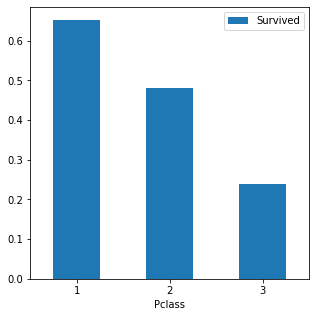

In [64]:
#등급과 생존률 간의 상관관계 시각화
pcl_to_sur.plot(kind="bar", x='Pclass', y='Survived', figsize=(5,5), rot=0)

In [65]:
#train2 데이터에서 sex별 생존확률에 대한 내림차순 정렬
sex_to_sur = train2[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)
train2[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.752896
1,male,0.205298


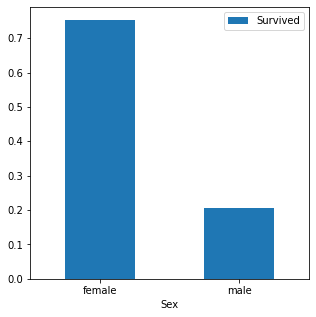

In [66]:
#sex와 생존률 간의 상관관계 시각화
sex_to_sur.plot(kind="bar", x='Sex', y='Survived', figsize=(5,5), rot=0)

In [67]:
#train2 데이터에서 같이 배에 탄 형제자매-배우자 수 별 생존확률에 대한 내림차순 정렬
sib_to_sur = train2[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)
train2[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.530055
2,2,0.440000
0,0,0.368870
3,3,0.333333
4,4,0.166667
5,5,0.000000


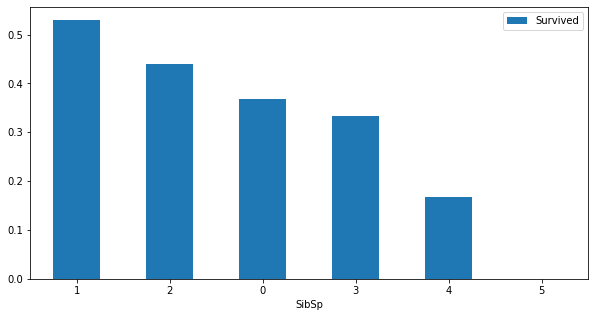

In [68]:
#SibSp와 생존률 간의 상관관계 시각화
sib_to_sur.plot(kind="bar", x='SibSp', y='Survived', figsize=(10,5), rot=0)

In [69]:
#train2 데이터에서 부모자식 수 별 생존확률에 대한 내림차순 정렬
par_to_sur = train2[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)
train2[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
2,2,0.573529
1,1,0.554545
0,0,0.354528
5,5,0.200000
4,4,0.000000
6,6,0.000000


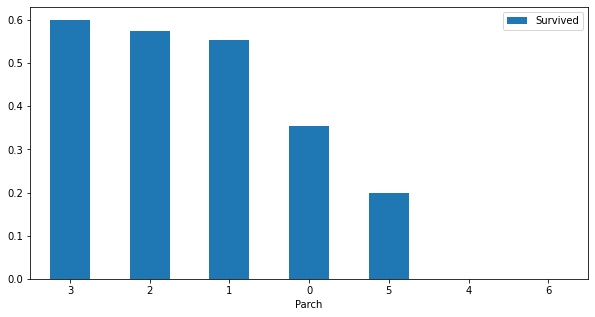

In [70]:
#Parch와 생존률 간의 상관관계 시각화
par_to_sur.plot(kind="bar", x='Parch', y='Survived', figsize=(10,5), rot=0)

In [71]:
#train2 승선지 별 생존확률에 대한 내림차순 정렬
emb_to_sur = train2[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)
train2[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.607692
2,S,0.362816
1,Q,0.285714


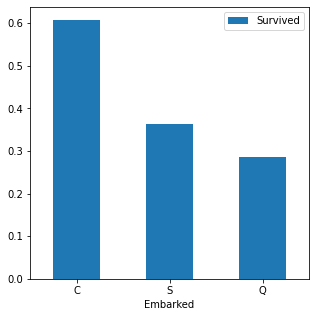

In [72]:
#Embarked와 생존률 간의 상관관계 시각화
emb_to_sur.plot(kind="bar", x='Embarked', y='Survived', figsize=(5,5), rot=0)

In [73]:
#생존한 사람-Pclass 별 낸 요금의 평균 내림차순 정렬
far_to_sur = train2[['Pclass','Fare','Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)
far_to_sur

,Pclass,Fare,Survived
0,1,88.048121,0.652174
1,2,21.471556,0.479769
2,3,13.229435,0.239437


,Survived,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,0.404494,2.240169,29.642093,0.514045,0.432584,34.567251
std,0.491139,0.836854,14.492933,0.930692,0.854181,52.938648
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,20.000000,0.000000,0.000000,8.050000
50%,0.000000,2.000000,28.000000,0.000000,0.000000,15.645850
75%,1.000000,3.000000,38.000000,1.000000,1.000000,33.000000
max,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


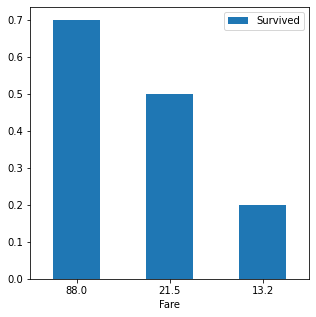

In [74]:
#Pclass 별 Fare와 생존률 간의 상관관계 시각화
round(far_to_sur, 1).plot(kind="bar", x='Fare', y='Survived', figsize=(5,5), rot=0)
train2.describe()

#요금은 요금 구간별

In [75]:
#train2 나이 별 생존확률에 대한 내림차순 정렬
age_to_sur = train2[['Pclass', 'Age', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)
round(age_to_sur, 1)

,Pclass,Age,Survived
0,1,38.1,0.7
1,2,29.9,0.5
2,3,25.1,0.2


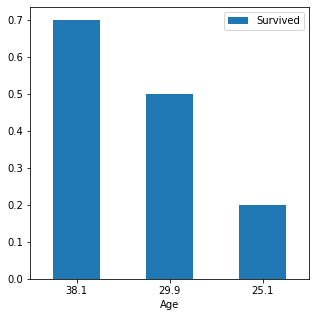

In [76]:
#Pclass별 Age와 생존률 간의 상관관계 시각화
round(age_to_sur,1).plot(kind="bar", x='Age', y='Survived', figsize=(5,5), rot=0)


각 특성 별 생존여부와의 1:1 대응관계 분석

---

 - pcl to sur

    등급이 높을 수록 생존확률이 비례해서 올라갔다.



 - sex to sur

    여성이 남성보다 생존확률이 높았다.

    **등급-성별에 대한 생존확률을 한번 점검해보아야겠다.**



 - sib to sur

    같이 동승한 지인의 수가 1 2 0 3 4 5 순으로 낮아졌다.

    동승한 지인의 수가 많아질수록 생존확률이 낮아지는것이 관측되었다.

    특이하게 1,2 가 0보다 생존확률이 높았고 5는 생존확률이 0이다.



 - par to sur
  
    같이 배에탄 부모 자식 수는 3 2 1 0 5 4 6 순으로 낮아졌다.

    동승자가 너무 많아지면 생존확률은 0에 수렴했다.

    **sib to sur과 par to sur은 동승자수 별 비율을 좀 확인해봐야겠다.**



 - emb to sur

    승선지 별 생존확률이 신기하게 C-S-Q순으로 차이가 났다.
    
    **C-S-Q 와 등급(Pclass)을 엮어서 한번 생존확률을 확인해봐야겠다.**

    **더 심화로 요금, 승선지, 등급을 엮어도 좋아보인다.**


 - far to sur

    **요금 구간 별 생존확률로 다시 분석을 해보아야겠다.**

#자료간 상관관계 - 히트맵으로 시각화

In [77]:
#히트맵 작성을 위한 트레인데이터 자료간 상관관계
train2.corr().abs()

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,0.356462,0.082446,0.015523,0.095265,0.266100
Pclass,0.356462,1.000000,0.365902,0.065187,0.023666,0.552893
Age,0.082446,0.365902,1.000000,0.307351,0.187896,0.093143
SibSp,0.015523,0.065187,0.307351,1.000000,0.383338,0.139860
Parch,0.095265,0.023666,0.187896,0.383338,1.000000,0.206624
Fare,0.266100,0.552893,0.093143,0.139860,0.206624,1.000000


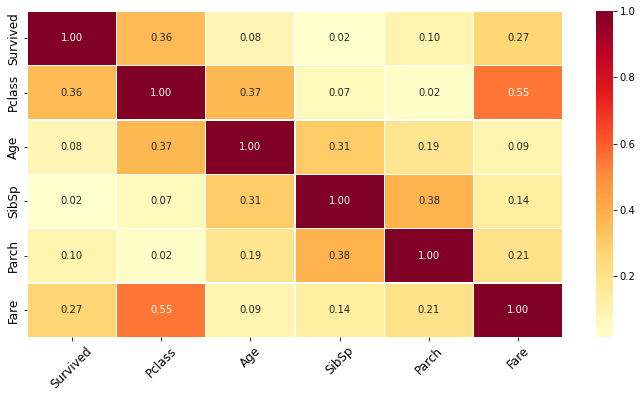

In [78]:
#각 특성 별 상관관계

fig, ax = plt.subplots(figsize=(12,6))

sns.heatmap(train2.corr().abs(), # 위에서 전처리한 데이터프레임
            annot = True, # 숫자 표시 여부
            ax = ax, # 히트맵을 그릴 격자
            linewidths = 0.4, # 선의 굵기
            linecolor = 'white', # 선의 색깔
            fmt = '.2f', # 소수점 포맷팅 형태
            cmap = 'YlOrRd') # colormap 형태

plt.xticks(rotation=45, size = 12)
plt.yticks(size=12) 
plt.show()

Pclass와 Fare은 반비례관계로 0.6값을 지니며 가장 선형적으로 보인다.

Pclass-survived 0.4
sibsp-parch 0.4
Fare Survived 0.3

성별을 0과 1로 나누어 생존간의 상관관계까지 보고싶다.

*** 각각의 데이터를 상관관계 분석에서 시각적으로 보인 바의 크기대로 점수를 부여하였다. ***

#자료 분석을 기반으로한 자료 치환과정

In [79]:
#자료 전처리과정
train3 = train2.replace(['male','female'],[10,20])
train3 = train3.replace(['C', 'S', 'Q'],[30,20,10])
train3['SibSp'] = train3['SibSp'].replace([1,2,0,3,4,5],[60,50,40,30,20,10])
train3['Parch'] = train3['Parch'].replace([3,2,1,0,5,4,6],[70,60,50,40,30,20,10])
train3['Pclass'] = train3['Pclass'].replace([1,2,3],[90,60,30])

In [80]:
#전처리한 데이터를 사용할 항목별로 쪼개서 준비

#sur_train_input -> train.csv에서 전처리한 데이터-> input,target준비
sur_train_input = train3[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']].to_numpy()
sur_train_target = train3[['Survived']].to_numpy()

#전처리한 데이터들을 array형식으로 바꾸고 검증을 위해 sur_train 데이터들을 train과 val(test)데이터로 나눔
train_input, test_input, train_target, test_target = train_test_split(sur_train_input, sur_train_target, random_state=42)

#target 형식을 재조정해줌
train_target = train_target.reshape(-1)
train_target.shape

test_target = test_target.reshape(-1)
test_target.shape

(178,)

In [81]:
#모델 검증을 위한 test.csv파일 데이터 전처리과정
test_df_f = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/titanic/test.csv')
test_df_f.drop(['PassengerId','Ticket', 'Cabin'], axis=1, inplace =True)

test_df_f = test_df_f.replace(['male','female'],[10,20])
test_df_f = test_df_f.replace(['C','S','Q'],[30,20,10])
test_df_f['Pclass']= test_df_f['Pclass'].replace([1,2,3],[9,6,3])
test_df_f['SibSp'] = test_df_f['SibSp'].replace([1,2,0,3,4,5],[60,50,40,30,20,10])
test_df_f['Parch'] = test_df_f['Parch'].replace([3,2,1,0,5,4,6],[70,60,50,40,30,20,10])
test_df_f['Age'] = test_df_f['Age'].fillna(test_df_f.groupby('Pclass')['Age'].transform('mean'))
test_df_f['Fare'] = test_df_f['Age'].fillna(method = 'ffill')

test_target_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/titanic/gender_submission.csv')
sur_test_input = test_df_f[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']].to_numpy()
sur_test_target = test_target_df[['Survived']].to_numpy()

sur_test_input.shape
sur_test_target = sur_test_target.reshape(-1)

#전처리 데이터를 활용한 간단한 머신러닝모델 구현

train3 데이터로 로지스틱 회귀모델 학습 후 test3에 대한 점수 출력

In [82]:
lr = LogisticRegression()
lr.fit(train_input, train_target)
lr.score(sur_train_input, sur_train_target)
log_predict = lr.predict(sur_test_input)
lr_score = lr.score(test_input, test_target)

print("lr-모델 훈련데이터 점수 :",lr.score(train_input, train_target))
print("lr-모델 검증데이터 점수:",lr_score)

lr-모델 훈련데이터 점수 : 0.8146067415730337
lr-모델 검증데이터 점수: 0.7865168539325843


랜덤포레스트로 모델링

In [83]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(train_input, train_target)

print("rf-모델 검증데이터 점수:",rf.score(test_input, test_target))

rf-모델 검증데이터 점수: 0.7865168539325843


#특성공학을 활용한 특성추가

특성 간 상관관계 분석이 가능한 지식이 아직 부족한 상태(선형대수,통계학..등)

따라서 특성공학을 통해 차원에 따른 특성개수를 늘려 학습해보기로 하였다.

특성 공학으로 특성 늘린 후 랜덤포레스트로 모델링

In [84]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit(train_input)
train_poly = poly.transform(train_input)
test_poly = poly.transform(test_input)

rf_poly = RandomForestClassifier(n_jobs=-1)
rf_poly.fit(train_poly, train_target)
rf_poly_score = rf_poly.score(test_poly, test_target)
print("rf-모델 poly 검증데이터 점수:",rf_poly_score)

rf-모델 poly 검증데이터 점수: 0.797752808988764


#특성 공학으로 특성 늘린 후 정규화 작업 진행, KNN, RF...으로 모델링

특성을 단순히 늘려보았더니 점수가 오히려 떨어짐을 관찰하였고

차원을 증가시킬수록 훈련 데이터에 과적합만 발생 할 것 같아 다른 시도를 하였다.

자료간 스케일이 맞지 않다고 생각하여 자료의 스케일을 맞춰주기위해 정규화 작업을 진행하였다.

RF로 모델링

In [85]:
ss= StandardScaler()
ss.fit(train_poly)
train_scaled = ss.transform(train_poly)
test_scaled = ss.transform(test_poly)

rf_scaled = RandomForestClassifier(n_jobs=-1)
rf_scaled.fit(train_scaled, train_target)
rf_scaled.score(test_scaled, test_target)
print("rf-모델 poly-scaled-검증데이터 점수:",rf_scaled.score(test_scaled, test_target))

rf-모델 poly-scaled-검증데이터 점수: 0.797752808988764


KNN으로 모델링

In [86]:
kn = KNeighborsClassifier()
kn.fit(train_scaled, train_target)
kn.score(test_scaled, test_target)
print("kn-모델 poly-score-검증데이터 점수:",kn.score(test_scaled, test_target))

kn-모델 poly-score-검증데이터 점수: 0.7865168539325843


# 주성분 분석으로 과대적합을 막고 최적의 요소 찾아서 모델링

특성을 늘리고 정규화까지 진행하였지만 뚜렷한 모델점수 개선이 되지 않았다.

따라서 이를 해결하기위해 PCA를 통해 특성을 줄여 학습해보았다.

In [87]:
#자료의 특성을 50퍼센트 가량 담을 수 있게 componets값을 정해보았다.
pca = PCA(n_components = 0.5)
pca.fit(train_input)
train_pca = pca.transform(train_input)
test_pca = pca.transform(test_input)
rf.fit(train_pca, train_target)
rf.score(test_pca, test_target)
print("rf-모델 poly-scaled-pca-검증데이터 점수:",rf.score(test_pca, test_target))

rf-모델 poly-scaled-pca-검증데이터 점수: 0.6179775280898876


In [88]:
pca = PCA(n_components = 20)
pca.fit(train_poly)
train_pca = pca.transform(train_poly)
test_pca = pca.transform(test_poly)

rf.fit(train_pca, train_target)
rf.score(test_pca, test_target)
#주성분을 20개 사용
print("rf-모델 poly-scaled-pca-검증데이터 점수:",rf.score(test_pca, test_target))

rf-모델 poly-scaled-pca-검증데이터 점수: 0.7528089887640449


특성의 개수를 더 늘려서 다양한 모델에 적용

In [89]:
poly = PolynomialFeatures(degree=3, include_bias=False)
poly.fit(train_input)
train_poly = poly.transform(train_input)
test_poly = poly.transform(test_input)

pca = PCA(n_components = 50)
pca.fit(train_poly)
train_pca = pca.transform(train_poly)
test_pca = pca.transform(test_poly)

rf.fit(train_pca, train_target)
rf.score(test_pca, test_target)
round(rf.score(test_pca, test_target), 4)*100

75.28

In [90]:
kn.fit(train_pca, train_target)
kn.score(test_pca, test_target)


0.7303370786516854

#미완성 셀 

In [91]:
# import math

# scoreboard = {}

# for deg in range(2,6+1):
#   poly = PolynomialFeatures(degree=deg)
#   poly.fit(train_input)
#   train_poly = poly.transform(train_input)
#   test_poly = poly.transform(test_input)

#   x = math.factorial(7+deg)/(math.factorial(7)*math.factorial(deg))
  

#   for com in range(3, int(x)):
#     pca = PCA(n_components = com)
#     pca.fit(train_poly)
#     train_pca = pca.transform(train_poly)
#     test_pca = pca.transform(test_poly)

#     rf.fit(train_pca, train_target)
#     rf.score(test_pca, test_target)

#     scoreboard["rf - deg = {}, com = {}".format(deg, com)] = round(rf.score(test_pca, test_target), 4)*100

# len(scoreboard)
# list(scoreboard.values())
# print(max(list(scoreboard.values())))
# print(list(scoreboard.values()).index(max(list(scoreboard.values()))))

# max_key=list(scoreboard.keys())[list(scoreboard.values()).index(max(list(scoreboard.values())))]
# print(list(scoreboard.keys())[list(scoreboard.values()).index(max(list(scoreboard.values())))])
# print(scoreboard[max_key])

#for문을 통한 최적의 degree 및 components 개수 찾기(완성하였지만 돌리지않음)

In [92]:
# scoreboard_lr = {}
# scoreboard_rf = {}
# scoreboard_kn = {}

# kn = KNeighborsClassifier()
# lr = LogisticRegression(max_iter=500, n_jobs=-1)
# rf = RandomForestClassifier(n_jobs=-1)


# for deg in range(2,4+1):
#   poly = PolynomialFeatures(degree=deg)
#   poly.fit(train_input)
#   train_poly = poly.transform(train_input)
#   test_poly = poly.transform(test_input)

#   ss.fit(train_poly)
#   train_scaled = ss.transform(train_poly)
#   test_scaled = ss.transform(test_poly)

#   x = math.factorial(7+deg)/(math.factorial(7)*math.factorial(deg))
  

#   for com in range(3, int(x)):
#     pca = PCA(n_components = com)
#     pca.fit(train_scaled)
#     train_pca = pca.transform(train_scaled)
#     test_pca = pca.transform(test_scaled)

#     lr.fit(train_pca, train_target)
#     rf.fit(train_pca, train_target)
#     kn.fit(train_pca, train_target)
    
#     scoreboard_lr["lr - deg = {}, com = {}".format(deg, com)] = round(lr.score(test_pca, test_target), 3)*100
#     scoreboard_rf["rf - deg = {}, com = {}".format(deg, com)] = round(rf.score(test_pca, test_target), 3)*100
#     scoreboard_kn["kn - deg = {}, com = {}".format(deg, com)] = round(kn.score(test_pca, test_target), 3)*100

# max_value = max(list(scoreboard_lr.values()))
# mvalue_index = list(scoreboard_lr.values()).index(max_value)
# max_key=list(scoreboard_lr.keys())[mvalue_index]

# print("lr 모델의 최적의 조합 :", list(scoreboard_lr.keys())[mvalue_index])
# print("최고점수 : ", scoreboard_lr[max_key])

# max_value = max(list(scoreboard_rf.values()))
# mvalue_index = list(scoreboard_rf.values()).index(max_value)
# max_key=list(scoreboard_rf.keys())[mvalue_index]

# print("rf 모델의 최적의 조합 :", list(scoreboard_rf.keys())[mvalue_index])
# print("최고점수 : ", scoreboard_rf[max_key])

# max_value = max(list(scoreboard_kn.values()))
# mvalue_index = list(scoreboard_kn.values()).index(max_value)
# max_key=list(scoreboard_kn.keys())[mvalue_index]

# print("kn 모델의 최적의 조합 :", list(scoreboard_kn.keys())[mvalue_index])
# print("최고점수 : ", scoreboard_kn[max_key])

#각각의 ML모델의 파라미터값 조정(완성하였지만 돌리지않음)

max_iter값이 충분하지않아 100에서 500으로 조정

In [93]:
# lr = LogisticRegression(max_iter=500, n_jobs=-1)

# poly = PolynomialFeatures(degree=3)
# poly.fit(train_input)
# train_poly = poly.transform(train_input)
# test_real_poly = poly.transform(sur_test_input)

# ss.fit(train_poly)
# train_scaled = ss.transform(train_poly)
# test_real_scaled = ss.transform(test_real_poly)

# pca = PCA(n_components = 36)
# pca.fit(train_scaled)
# train_pca = pca.transform(train_scaled)
# test_real_pca = pca.transform(test_real_scaled)

# lr.fit(train_pca, train_target)
# predict = lr.predict(test_real_pca)
# accuracy = accuracy_score(predict, sur_test_target)


# predict = lr.predict(test_real_pca)
# accuracy = accuracy_score(predict, sur_test_target)
# test_real_poly = poly.transform(sur_test_input)
# test_real_scaled = ss.transform(test_real_poly)
# test_real_pca = pca.transform(test_real_scaled)
# accuracy

#특성공학의 degree, PCA 차원축소의 n_components 파라미터 값의 변화에 따른
#test.csv data의 predict accuracy 최대값 도출



In [94]:
scoreboard_lr = {} #로지스틱 회귀 모델 반복문 결과 저장소
scoreboard_rf = {} #랜덤포레스트 -
scoreboard_kn = {} #KNN

#각각의 머신러닝 모델 클래스 지정
#max_iter()은 특성값이 증가함에 따라 충분히 학습하지 못하는 경우를 대비하여 늘림

kn = KNeighborsClassifier()
lr = LogisticRegression(max_iter=500, n_jobs=-1)
rf = RandomForestClassifier(n_jobs=-1)

#차원은 2차에서 4차까지 늘려가며
#중간에 계산된 x는 특성공학으로 인해 늘어난 특성의 개수를 계산한 식
# x = (기존 데이터 특성개수+degree)! / (degree! * 기존 데이터 특성개수!)

for deg in range(2,4+1):
  poly = PolynomialFeatures(degree=deg)
  poly.fit(train_input)
  train_poly = poly.transform(train_input)
  test_poly = poly.transform(test_input)
  test_real_poly = poly.transform(sur_test_input)

  ss.fit(train_poly)
  train_scaled = ss.transform(train_poly)
  test_scaled = ss.transform(test_poly)
  test_real_scaled = ss.transform(test_real_poly)

  x = math.factorial(7+deg)/(math.factorial(7)*math.factorial(deg))
  
#주특성 사용개수를 3개부터 계산된 x-1개까지 사용
  for com in range(3, int(x)):
    pca = PCA(n_components = com)
    pca.fit(train_scaled)
    train_pca = pca.transform(train_scaled)
    test_pca = pca.transform(test_scaled)
    test_real_pca = pca.transform(test_real_scaled)

    lr.fit(train_pca, train_target)
    rf.fit(train_pca, train_target)
    kn.fit(train_pca, train_target)



#각각 훈련된 모델을통해 test.csv의 결과를 도출
#그 결과를 scoeboard에 저장   
    scoreboard_lr["lr - deg = {}, com = {}".format(deg, com)] = round(accuracy_score(lr.predict(test_real_pca), sur_test_target), 4)*100
    scoreboard_rf["rf - deg = {}, com = {}".format(deg, com)] = round(accuracy_score(rf.predict(test_real_pca), sur_test_target), 4)*100
    scoreboard_kn["kn - deg = {}, com = {}".format(deg, com)] = round(accuracy_score(kn.predict(test_real_pca), sur_test_target), 4)*100

#scoreboard 딕셔너리 안에 들어있는 결과중 최고값을 도출하는 구문
max_value = max(list(scoreboard_lr.values()))
mvalue_index = list(scoreboard_lr.values()).index(max_value)
max_key=list(scoreboard_lr.keys())[mvalue_index]

print("lr 모델의 최적의 조합 :", list(scoreboard_lr.keys())[mvalue_index])
print("최고점수 : ", scoreboard_lr[max_key])

max_value = max(list(scoreboard_rf.values()))
mvalue_index = list(scoreboard_rf.values()).index(max_value)
max_key=list(scoreboard_rf.keys())[mvalue_index]

print("rf 모델의 최적의 조합 :", list(scoreboard_rf.keys())[mvalue_index])
print("최고점수 : ", scoreboard_rf[max_key])

max_value = max(list(scoreboard_kn.values()))
mvalue_index = list(scoreboard_kn.values()).index(max_value)
max_key=list(scoreboard_kn.keys())[mvalue_index]

print("kn 모델의 최적의 조합 :", list(scoreboard_kn.keys())[mvalue_index])
print("최고점수 : ", scoreboard_kn[max_key])
#--------------------------------------------------------------

lr 모델의 최적의 조합 : lr - deg = 2, com = 4
최고점수 :  85.89
rf 모델의 최적의 조합 : rf - deg = 4, com = 23
최고점수 :  90.67
kn 모델의 최적의 조합 : kn - deg = 4, com = 4
최고점수 :  90.42999999999999


#1차 결론 및 자가 피드백
---

1. 현재 과적합이 가장 많이 되지않은 로지스틱 회귀모델이 일반적인 모델로 쓰기 적합할 것이라는 생각이 든다. 85.89점의 비교적 준수한 점수라고 생각된다.

 - rf 모델의 점수가 가장 높게 나왔고 90.67점이지만 현재 4차원 특성에 주성분을 23개 사용하였기 때문에 현재 test.csv데이터에 과적합 되어있을 확률이 높다. 

 - kn모델은 비교적 주성분을 적게 사용하였고 lr모델도 주성분의 개수가 4개인것을 보아 lr모델과 kn모델의 작동 알고리즘이 유사할지 차후 검토해보고싶다.

 - 주성분으로 사용된 4개의 특성들의 식을 보면서 내가 몰랐던 특성관의 상관관계를 살펴보면 좋겠다.


2. 또한 rf모델이 오늘 낮에 돌렸을 당시 92.58점이라는 스코어를 받았는데 random_state값을 지정해주지 않아 나눠진 트레이닝 데이터가 달라짐으로 점수에 변화를 주는 것 같다.
 - 이는 차후에 random_state의 변화를 주어 개선해보겠다.
 - 또는 cross_validate  방법을 사용해 전체데이터를 빠짐없이 학습하는 방법도 고려해보겠다.



3. 현재 머신러닝 모델을 랜덤포레스트, 로지스틱회귀모델, KNN의 3개의 학습방법만 사용하였지만 차후에 결정트리나 또 다른 모델들을 적용시키면 좋을 것 같다.



4. 가장 아쉬운 점은 전처리 과정에서의 값을 치환하는 방법이다. 아직 통계학이나 데이터 분석의 지식이 없기 때문에 이를 해결하려고 나름 유의미한 값을 넣어 보았다. 

 - 하지만 거의 근거없는 추측에 의한 치환이라 차후 유의미한 전처리 방법을 공부 해야겠다.



5. 현재 구현해놓은 방법은 test.csv의 예측점수를 가장 높게 가져오는 모델을 자연스럽게 찾도록 구현해 놓았지만 이는 답지를 참조한 것과 같은 맥락이기 때문에 옳지 못한 방법이라는 것을 깨달았다.


6. One-Hot-Encoding 방법에 대해서 더 공부해 보아야겠다. 분류가 가능한 데이터에 대해서 스케일이 존재하는 어떤 값으로 넣는 방법보다 좋다는 제언을 들었다.



7. 아직 데이터 중 age,fare 데이터는 스킬이 부족하여 특별한 전처리 과정 없이 있는 데이터를 넣었다. 원래 계획은 age와 fare을 구간으로 나누고 구간 별 생존확률을 계산 후 관측값에 어느정도 비례하게 점수를 부여 할 생각이었다.



8. pandas dataframe의 편집 기술과 seaborn, matplotlib 모듈의 그래프 구현하는 기술이 아직 많이 부족하기 때문에 앞으로 더 발전해야겠다.



9. 현재 파라미터 조작을 특성과 주성분 개수를 변화시키는 방법으로 최적의 모델을 찾아 나갔다. 차후 더 다양한 하이퍼파라미터들을 변화시키면서 검증한다면 보다 효과적인 모델을 구현해 볼 수 있겠다는 생각이 들었다.



10. 데이터의 전처리 방법에 대한 고민
 - 로지스틱 회귀모델 사용을 위해 자료분석 후 데이터 전처리를 하던 중 로지스틱 회귀모델의 기본적인 방정식이 선형방정식으로 도출 된다는 점이 생각났다. 

 - z = ax +by +cz ... 와 같은 각각의 특성별 계수가 계산되고 특성이 들어가 z값이 구해지는 형식이다.

 - 여기서 구해진 z가 시그모이드 함수에 대입되면서 0~1사이의 확률로 타겟을 분류 하는 모델인데 현재 데이터의 구조를 보면 나이, 요금 등 값의 크기가 올라갈수록 생존확률이 올라가지 않음을 확인했다.

 - 이 문제를 어떻게 해결해볼지에 대한 고민 중 특성의 1:1 상관관계를 분석한 결과를 토대로 구간 별 점수를 부여하자는 생각이 들었다. 문자열 데이터 역시 데이터 분석을 기반으로 점수를 부여해보며 이를 해결하려고 시도했다.




---

